# Cache size

In [42]:
abs_path = "/home/cc/clio/libCacheSim/scripts/result"

# glob through all of folders in the dir
import os
import glob
import re
import pandas as pd

cache_sizes = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4]


for idx, file in enumerate(glob.glob(abs_path + "/*/result/*.zst")):
    # read file
    file_content = open(file, "r").read()
    # List to store the parsed rows
    data = []

    # Iterate through each line and parse
    idx = 0
    for line in file_content.split('\n'):
        # Use regular expression to extract relevant details
        # match = re.match(r'(.+)\s+(\w+)\s+cache size\s+(\d+\w+),\s+(\d+)\s+req, miss ratio\s+([\d.]+), byte miss ratio\s+([\d.]+)', line)
        match = re.match(r'(.+)\s+([\w\d.-]+)\s+cache size\s+(\d+\w+),\s+(\d+)\s+req, miss ratio\s+([\d.]+), byte miss ratio\s+([\d.]+)', line)
        if match:
            # Extract groups from regex
            file_name, cache_type, cache_size, req_count, miss_ratio, byte_miss_ratio = match.groups()
            cache_size = cache_sizes[idx% len(cache_sizes)]
            idx += 1
            # Append to data list as a tuple
            data.append((file_name.strip(), cache_type, cache_size, int(req_count), float(miss_ratio), float(byte_miss_ratio), float(cache_size)))

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['File name', 'Cache type', 'Cache size', 'Request count', 'Miss ratio', 'Byte miss ratio', 'cache_size'])
    # Save the DataFrame to a CSV file,
    # path is the same folder as file, but with .csv
    df.to_csv(file + ".csv", index=True)


/tmp/ipykernel_4049019/1129700031.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(


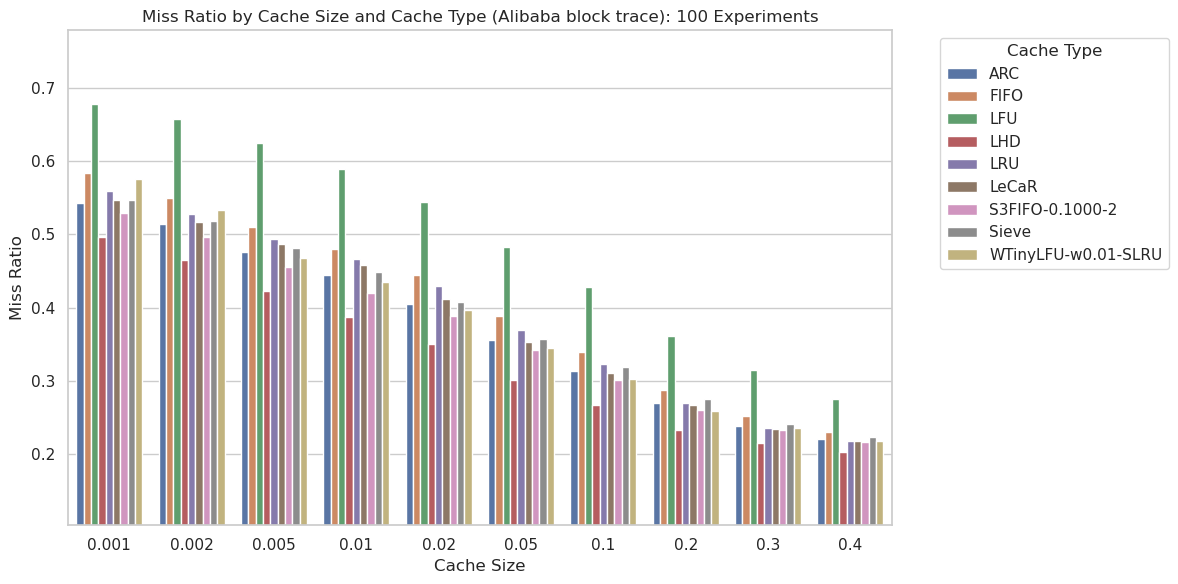

In [53]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import numpy as np

giant_df = pd.DataFrame()
max_idx = 0
for idx, file in enumerate(glob.glob(abs_path + "/*/result/*.csv")):
    df = pd.read_csv(file)
    giant_df = pd.concat([giant_df, df])
    max_idx = max(max_idx, idx)

# Convert 'Cache size' to a numeric type if it's not already
giant_df['Cache size'] = pd.to_numeric(giant_df['Cache size'], errors='coerce')

# Group the data by 'Cache type' and 'Cache size' to calculate the mean and standard deviation of the 'Miss ratio'
grouped_df = giant_df.groupby(['Cache type', 'Cache size']).agg(
    miss_ratio_mean=('Miss ratio', 'mean'),
    miss_ratio_std=('Miss ratio', 'std')
).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create a barplot
barplot = sns.barplot(
    x='Cache size',
    y='miss_ratio_mean',
    hue='Cache type',
    data=grouped_df,
    ci=None,
    # palette='viridis'
)

# Get the number of unique cache types and cache sizes
unique_cache_types = grouped_df['Cache type'].nunique()
unique_cache_sizes = grouped_df['Cache size'].nunique()



# Set labels and title
plt.xlabel('Cache Size')
plt.ylabel('Miss Ratio')
plt.title(f'Miss Ratio by Cache Size and Cache Type (Alibaba block trace): {max_idx} Experiments')
plt.legend(title='Cache Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the Y axis to start at minimum
min_val = grouped_df['miss_ratio_mean'].min()
max_val = grouped_df['miss_ratio_mean'].max()
#y lower limit set minval
plt.ylim(min_val-0.1, max_val+0.1)
# Show the plot
plt.tight_layout()
plt.show()


    Cache Size            Algorithm  Score
0        0.001                  LHD    232
1        0.001      S3FIFO-0.1000-2    135
2        0.001  WTinyLFU-w0.01-SLRU     97
3        0.001                  ARC     49
4        0.001                Sieve     46
..         ...                  ...    ...
79       0.400                  ARC     46
80       0.400                  LFU     43
81       0.400      S3FIFO-0.1000-2     36
82       0.400                Sieve     34
83       0.400                 FIFO      2

[84 rows x 3 columns]


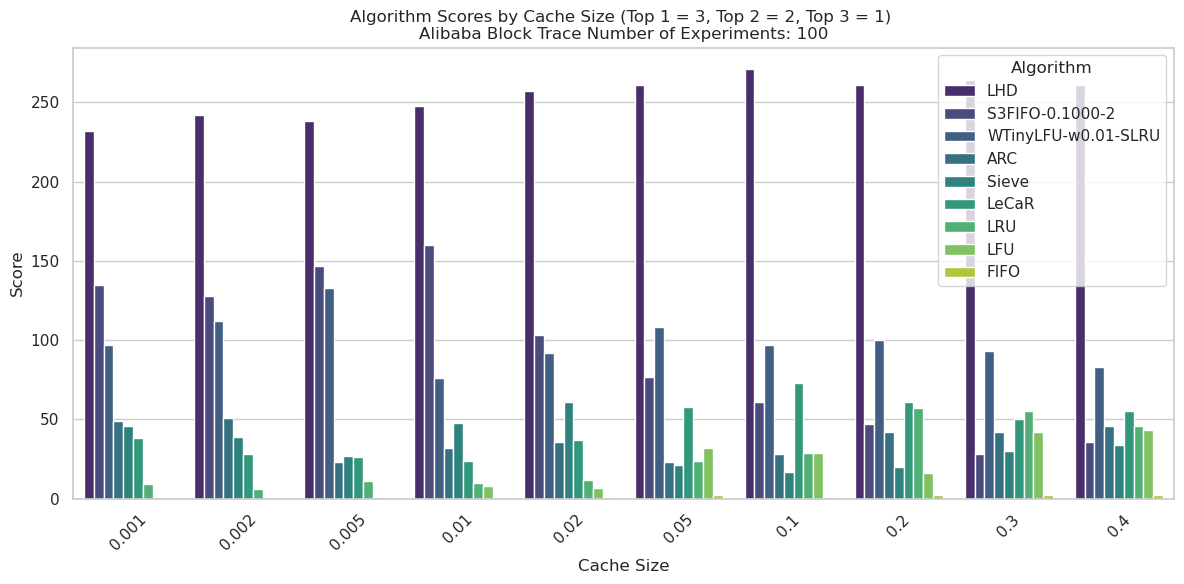

In [55]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt

# Dictionary to keep track of the cumulative points per algorithm for each cache size
cache_size_scores = {}

# Process each CSV file separately
for idx, file in enumerate(glob.glob(abs_path + "/*/result/*.csv")):
    df = pd.read_csv(file)
    
    # Convert 'Cache size' to a numeric type if it's not already
    df['Cache size'] = pd.to_numeric(df['Cache size'], errors='coerce')

    # Group by 'Cache size'
    for cache_size, group in df.groupby('Cache size'):
        # Sort by 'Miss ratio' in ascending order to get the best-performing algorithms (lowest miss ratio)
        top_3_algorithms = group.sort_values('Miss ratio').head(3).reset_index(drop=True)

        # Initialize the score dictionary for the cache size if not already done
        if cache_size not in cache_size_scores:
            cache_size_scores[cache_size] = {}

        # Assign points to the top 3 algorithms
        for rank, row in top_3_algorithms.iterrows():
            algorithm = row['Cache type']
            points = 3 - rank  # 1st place gets 3 points, 2nd place gets 2, 3rd place gets 1

            # Update the total score for the algorithm in the current cache size
            if algorithm in cache_size_scores[cache_size]:
                cache_size_scores[cache_size][algorithm] += points
            else:
                cache_size_scores[cache_size][algorithm] = points

# Convert the scores dictionary to a DataFrame for easier analysis
results = []
for cache_size, scores in cache_size_scores.items():
    for algorithm, score in scores.items():
        results.append({'Cache Size': cache_size, 'Algorithm': algorithm, 'Score': score})

scores_df = pd.DataFrame(results)

# Sort the DataFrame by 'Cache Size' and 'Score' in descending order to see the best algorithms for each cache size
scores_df = scores_df.sort_values(by=['Cache Size', 'Score'], ascending=[True, False]).reset_index(drop=True)

# Display the final rankings of algorithms based on the accumulated points, grouped by cache size
print(scores_df)

# Plotting the scores based on cache sizes
plt.figure(figsize=(12, 6))
sns.barplot(data=scores_df, x='Cache Size', y='Score', hue='Algorithm', palette='viridis')

plt.title(f'Algorithm Scores by Cache Size (Top 1 = 3, Top 2 = 2, Top 3 = 1) \nAlibaba Block Trace Number of Experiments: {max_idx}')
plt.xlabel('Cache Size')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Algorithm')
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


# Cache by time

In [72]:
abs_path = "/home/cc/clio/libCacheSim/scripts/result_"

# glob through all of folders in the dir
import os
import glob
import re
import pandas as pd

for idx, file in enumerate(glob.glob(abs_path + "/*/*.cachesim")):
    # read file
    file_content = open(file, "r").read()
    # List to store the parsed rows
    data = []

    # Iterate through each line and parse
    idx = 0
    for line in file_content.split('\n'):
        # Use regular expression to extract relevant details
        # match = re.match(r'(.+)\s+(\w+)\s+cache size\s+(\d+\w+),\s+(\d+)\s+req, miss ratio\s+([\d.]+), byte miss ratio\s+([\d.]+)', line)
        match = re.match(r'(.+)\s+([\w\d.-]+)\s+cache size\s+(\d+\w+),\s+(\d+)\s+req, miss ratio\s+([\d.]+), throughput\s+([\d.]+)\s+MQPS\s+(\d+)\s+Retrain-Interval', line)
        if match:
            # Extract groups from regex
            file_name, cache_type, cache_size, req_count, miss_ratio, throughput, retrain_interval= match.groups()
            # Append to data list as a tuple
            data.append((file_name.strip(), cache_type, cache_size, int(req_count), float(miss_ratio), float(throughput), float(retrain_interval)))
    # # Create a DataFrame
    df = pd.DataFrame(data, columns=['File name', 'Cache type', 'Cache size', 'Request count', 'Miss ratio', 'Throughput', 'Retrain Interval'])
    print(df)
    # # Save the DataFrame to a CSV file,
    # # path is the same folder as file, but with .csv
    df.to_csv(file + ".csv", index=True)

                                           File name Cache type Cache size  \
0  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     106MiB   
1  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     106MiB   
2  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     106MiB   

   Request count  Miss ratio  Throughput  Retrain Interval  
0        2200000      0.1999        2.48           86400.0  
1        2200000      0.2341        4.93         9999999.0  
2        2200000      0.2142        2.19           43200.0  
                                           File name Cache type Cache size  \
0  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache       1GiB   
1  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache       1GiB   
2  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache       1GiB   

   Request count  Miss ratio  Throughput  Retrain Interval  
0        7800000      0.1149        3.26           86400.0  
1       

                                           File name Cache type Cache size  \
0  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     223MiB   
1  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     223MiB   
2  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     223MiB   

   Request count  Miss ratio  Throughput  Retrain Interval  
0        8000000      0.2045        3.20           86400.0  
1        8000000      0.2523        5.59         9999999.0  
2        8000000      0.2069        3.08           43200.0  
                                           File name Cache type Cache size  \
0  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache       5GiB   
1  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache       5GiB   
2  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache       5GiB   

   Request count  Miss ratio  Throughput  Retrain Interval  
0        1600000      0.2177        1.94           86400.0  
1       

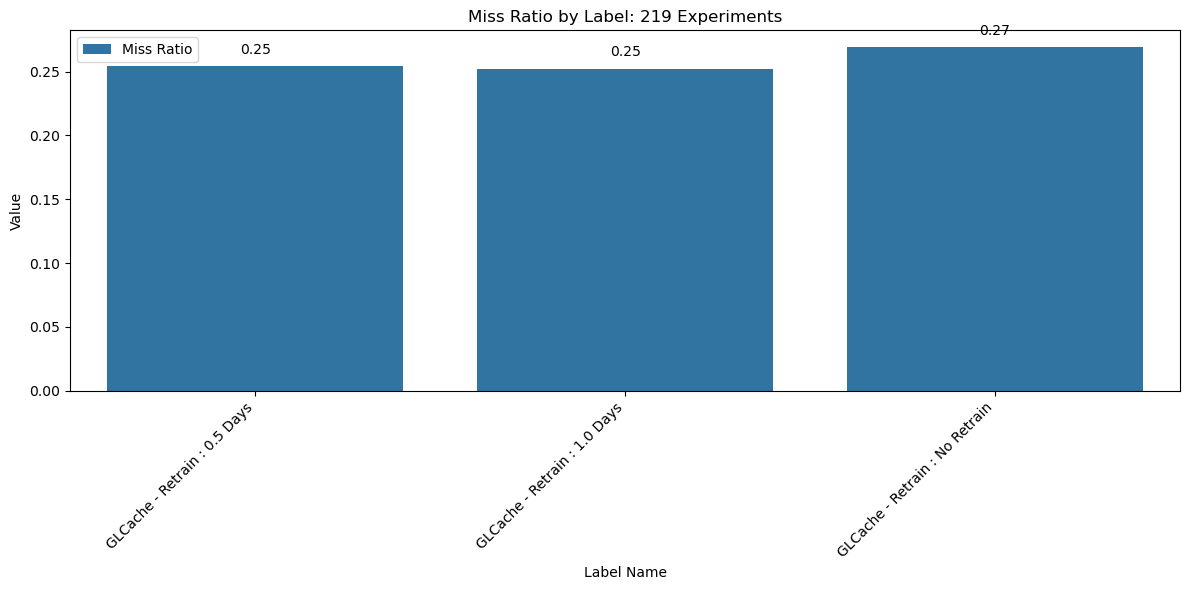

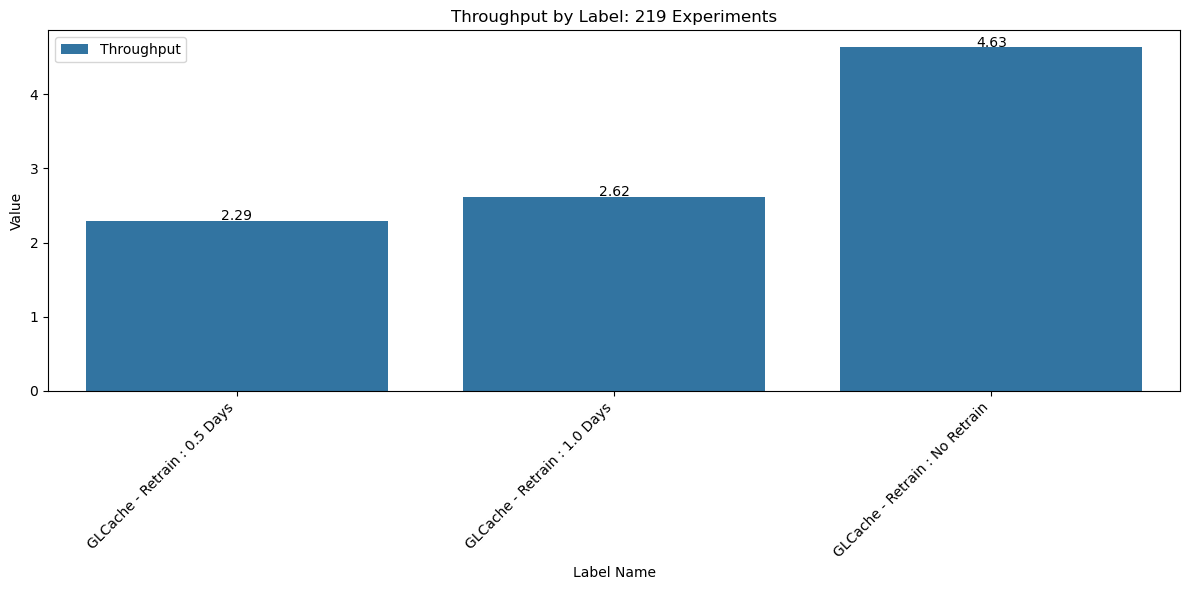

In [73]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import numpy as np

giant_df = pd.DataFrame()
max_idx = 0
for idx, file in enumerate(glob.glob(abs_path + "/*/*.csv")):
    df = pd.read_csv(file)
    df['File name'] = df['File name'].apply(lambda x: x.split("/")[-1])
    # df names with type - retrain interval, convert retrain interval to days first
    df['Label name'] = df['Cache type'] + " - Retrain : " + df['Retrain Interval'].apply(lambda x: (str(x/86400) + " Days") if x/86400 < 30 else "No Retrain") 
    giant_df = pd.concat([giant_df, df])
    max_idx = max(max_idx, idx)

# Average all of them out, with 'label name'
df_grouped = giant_df.groupby(['Label name']).agg(
    miss_ratio_mean=('Miss ratio', 'mean'),
    throughput_mean=('Throughput', 'mean'),
)

plt.figure(figsize=(12, 6))

# Plot miss_ratio_mean
sns.barplot(x='Label name', y='miss_ratio_mean', data=df_grouped, label='Miss Ratio')

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title(f"Miss Ratio by Label: {idx} Experiments")
plt.ylabel("Value")
plt.xlabel("Label Name")
plt.legend(loc='upper left')
plt.tight_layout()

for index, value in enumerate(df_grouped['miss_ratio_mean']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

# Show the plot
plt.show()

plt.figure(figsize=(12, 6))

# Plot miss_ratio_mean
sns.barplot(x='Label name', y='throughput_mean', data=df_grouped, label='Throughput')

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title(f"Throughput by Label: {idx} Experiments")
plt.ylabel("Value")
plt.xlabel("Label Name")
plt.legend(loc='upper left')
plt.tight_layout()

for index, value in enumerate(df_grouped['throughput_mean']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

# Show the plot
plt.show()






In [116]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import numpy as np

giant_df = pd.DataFrame()
max_idx = 0

for idx, file in enumerate(glob.glob(abs_path + "/*/*.csv")):
    df = pd.read_csv(file)
    df['File name'] = df['File name'].apply(lambda x: x.split("/")[-1])
    # df names with type - retrain interval, convert retrain interval to days first
    df['Label name'] = df['Cache type'] + " - Retrain : " + df['Retrain Interval'].apply(lambda x: (str(x/86400) + " Days") if x/86400 < 30 else "No Retrain")
    
    # sort by miss ratio
    highest_miss_ratio = df.sort_values('Miss ratio', ascending=False).head(1)
    no_retrain_is_highest = "No Retrain" in str(highest_miss_ratio['Label name'])
    
    threshold_bad = 0.5
    worst_miss = df['Miss ratio'].max() < threshold_bad
    
    df['Category'] = "GOOD" if (no_retrain_is_highest and not worst_miss) else "BAD"
    
    
    if no_retrain_is_highest and not worst_miss:
        if df['Miss ratio'].max() - df['Miss ratio'].min() >= 0.05:
            df['Category'] = "BEST"
    
    
    giant_df = pd.concat([giant_df, df])
    max_idx = max(max_idx, idx)


In [117]:
# count number of keep
print(giant_df['Category'].value_counts())

# print the best
# print the unique filename
giant_df[giant_df['Category'] == "BEST"]['File name'].unique()

Category
BAD     615
GOOD     27
BEST     18
Name: count, dtype: int64


array(['io_traces.ns284.oracleGeneral.zst',
       'io_traces.ns220.oracleGeneral.zst',
       'io_traces.ns119.oracleGeneral.zst',
       'io_traces.ns202.oracleGeneral.zst',
       'io_traces.ns792.oracleGeneral.zst',
       'io_traces.ns350.oracleGeneral.zst'], dtype=object)

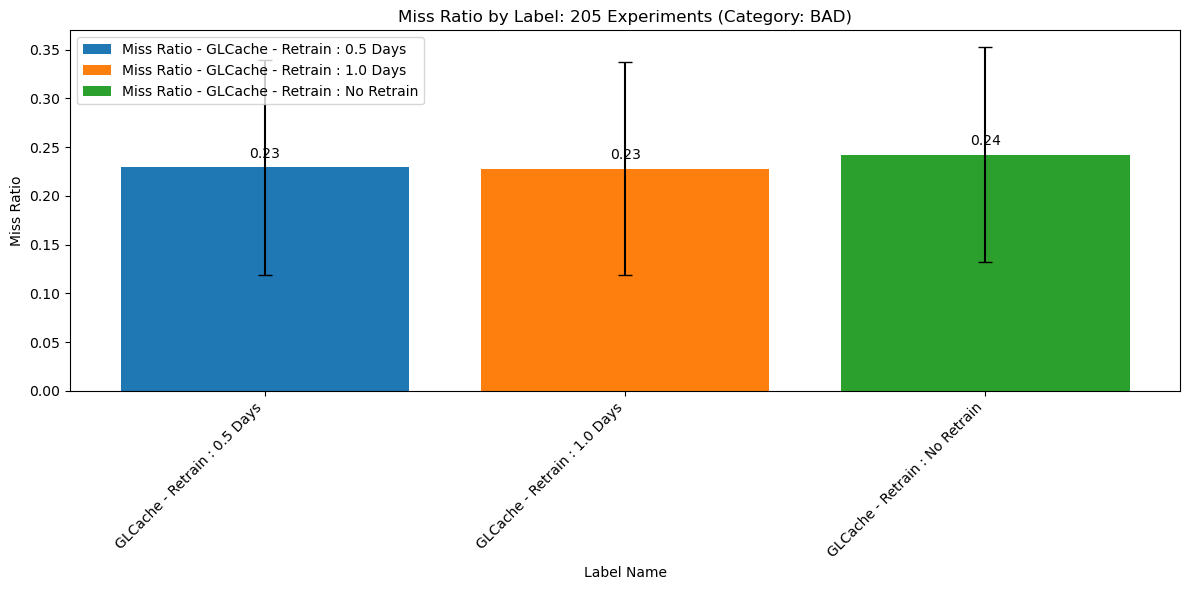

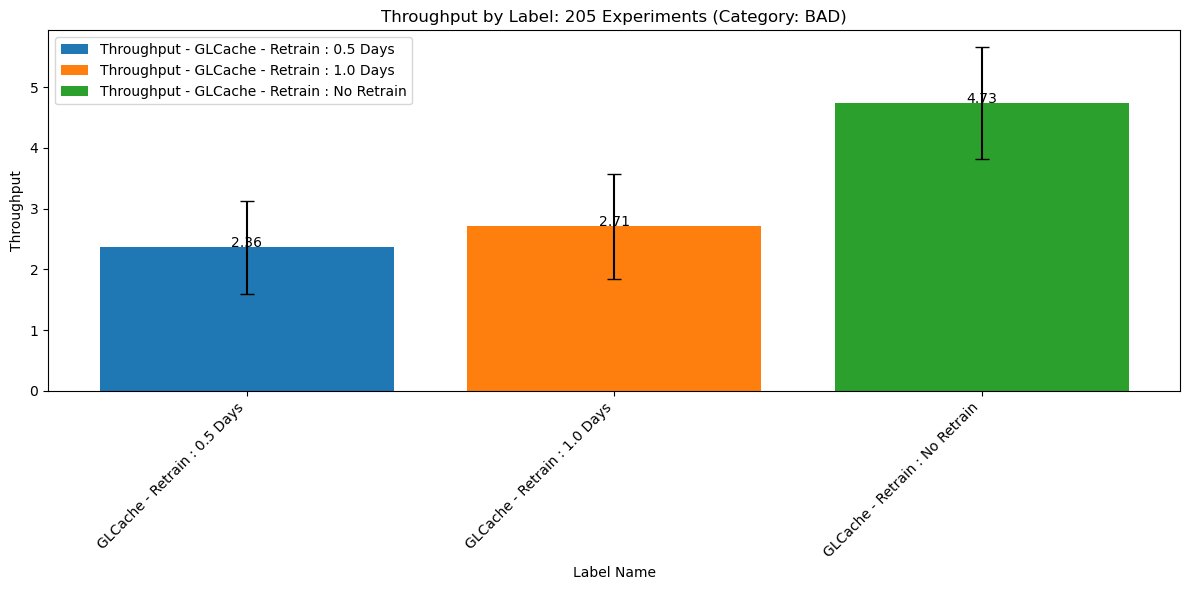

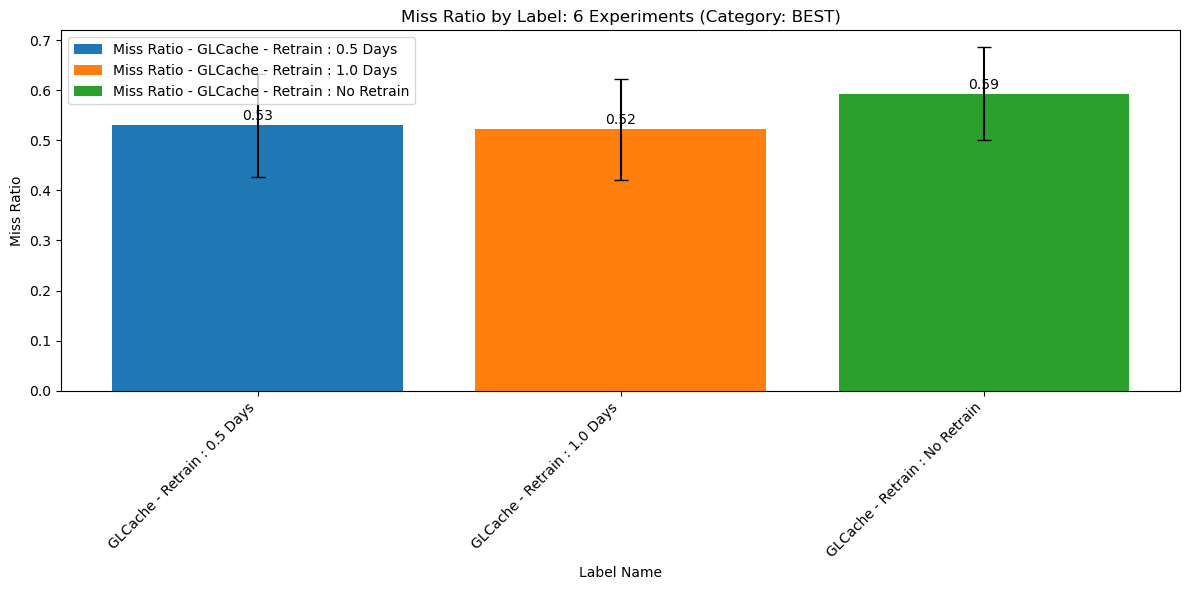

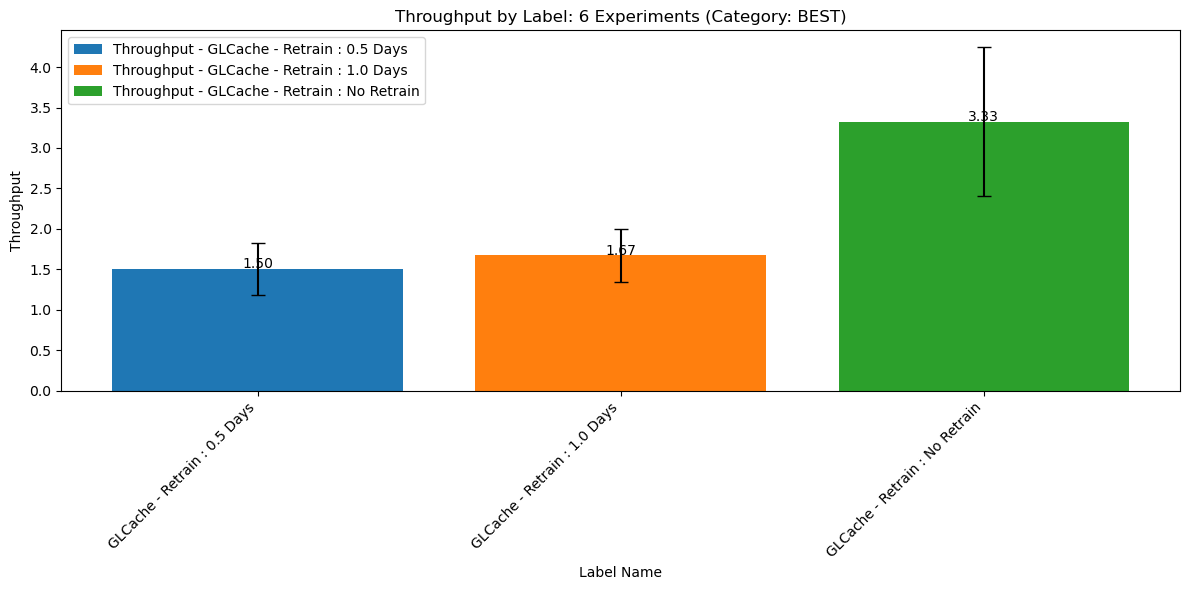

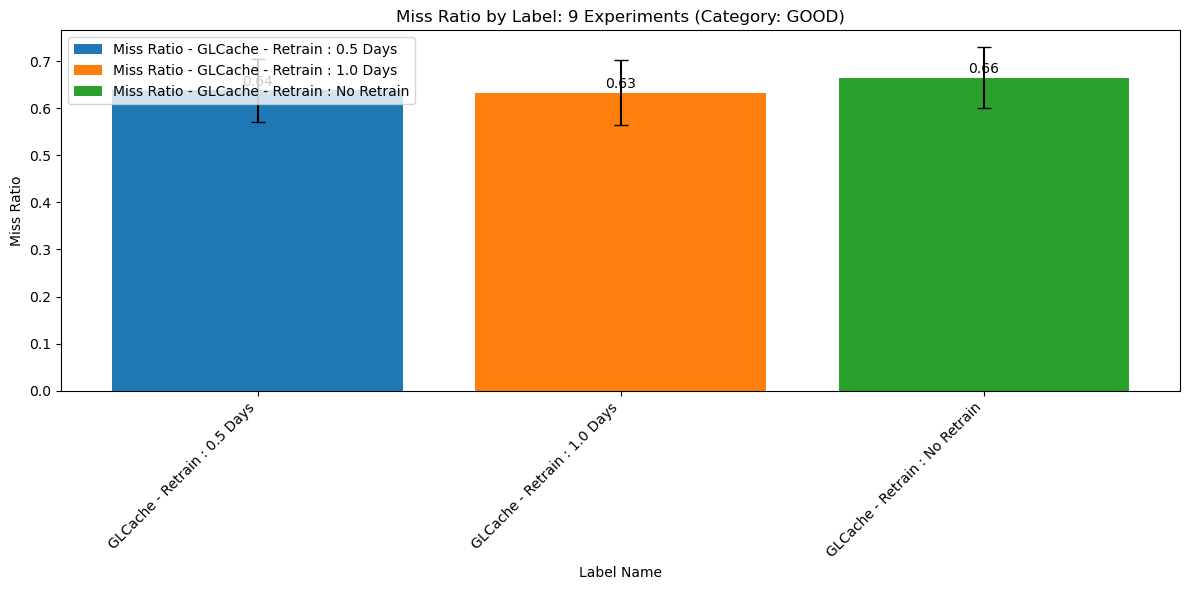

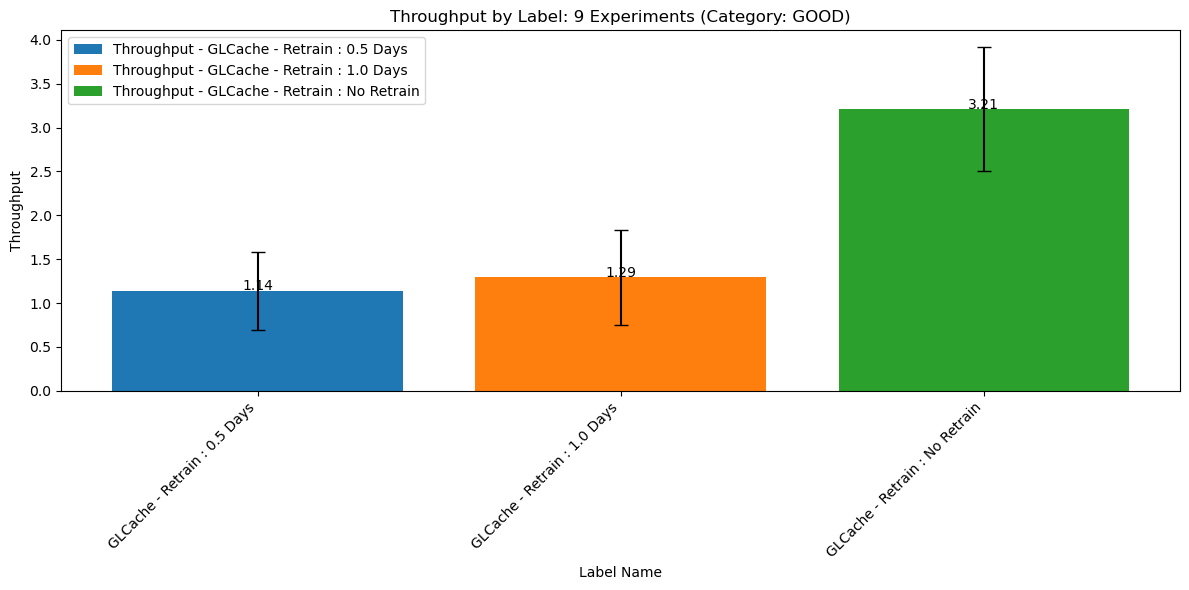

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define a function to plot Miss Ratio and Throughput with error bars
def plot_metrics_by_category(df, category_name, max_idx):
    # Filter by category
    df_filtered = df[df['Category'] == category_name]
    count_ = df_filtered['File name'].nunique()
    
    # Group by 'Label name' and calculate mean and standard deviation
    df_grouped = df_filtered.groupby(['Label name']).agg(
        miss_ratio_mean=('Miss ratio', 'mean'),
        miss_ratio_std=('Miss ratio', 'std'),
        throughput_mean=('Throughput', 'mean'),
        throughput_std=('Throughput', 'std')
    ).reset_index()
    
    # Plotting Miss Ratio
    plt.figure(figsize=(12, 6))
    for i, row in df_grouped.iterrows():
        plt.bar(row['Label name'], row['miss_ratio_mean'], yerr=row['miss_ratio_std'], capsize=5, label=f"Miss Ratio - {row['Label name']}")
        plt.text(i, row['miss_ratio_mean'] + 0.01, f'{row["miss_ratio_mean"]:.2f}', ha='center', fontsize=10)

    # Customize the plot for Miss Ratio
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Miss Ratio by Label: {count_} Experiments (Category: {category_name})")
    plt.ylabel("Miss Ratio")
    plt.xlabel("Label Name")
    plt.tight_layout()
    plt.legend(loc='upper left')
    plt.show()

    # Plotting Throughput
    plt.figure(figsize=(12, 6))
    for i, row in df_grouped.iterrows():
        plt.bar(row['Label name'], row['throughput_mean'], yerr=row['throughput_std'], capsize=5, label=f"Throughput - {row['Label name']}")
        plt.text(i, row['throughput_mean'] + 0.01, f'{row["throughput_mean"]:.2f}', ha='center', fontsize=10)

    # Customize the plot for Throughput
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Throughput by Label: {count_} Experiments (Category: {category_name})")
    plt.ylabel("Throughput")
    plt.xlabel("Label Name")
    plt.tight_layout()
    plt.legend(loc='upper left')
    plt.show()

# Loop through each unique category and generate plots
max_idx = giant_df['Label name'].nunique()  # Assuming max_idx is based on unique labels

for category in giant_df['Category'].unique():
    plot_metrics_by_category(giant_df, category, max_idx)


# Line Plot

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import re
import glob

# Set up colors and styles to support more variants
def plot_mrc_time(df, file_name="mrc_plot"):
    linestyles = itertools.cycle(["-", "--", "-.", ":"])
    
    # Expanded list of colors for more algorithms
    colors = itertools.cycle(
        [
            "navy", "darkorange", "tab:green", "cornflowerblue", "firebrick",
            "mediumvioletred", "darkgoldenrod", "slateblue", "teal", "darkslategray"
        ]
    )
    
    # Plotting setup
    plt.figure(figsize=(12, 6))

    # Iterate through each algorithm and plot it with transparency control
    for algo in df['Algorithm'].unique():
        algo_data = df[df['Algorithm'] == algo]
        
        # Make non 'every-day' algorithms more transparent
        alpha = 1.0 if 'every-day' in algo else 0.5
        
        sns.lineplot(
            data=algo_data,
            x='Time',
            y='Miss Ratio',
            label=algo,
            linewidth=2,
            linestyle=next(linestyles),
            color=next(colors),
            alpha=alpha,  # Transparency for non 'every-day'
        )
    
    # Axis labels and grid
    plt.xlabel("Time")
    plt.ylabel("Miss Ratio")
    plt.title(f"Miss Ratio over Time for {file_name}")
    plt.grid(axis="y", linestyle="--")
    
    # Legend outside the plot
    plt.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
    
    # plt.show()
    return plt
    


def plot_mrc_time_model(df, file_name="mrc_plot"):
    linestyles = itertools.cycle(["-", "--", "-.", ":"])
    
    # Expanded list of colors for more algorithms
    colors = itertools.cycle(
        [
            "navy", "darkorange", "tab:green", "cornflowerblue", "firebrick",
            "mediumvioletred", "darkgoldenrod", "slateblue", "teal", "darkslategray"
        ]
    )
    
    # Plotting setup
    plt.figure(figsize=(12, 6))

    unique_algorithms = df['Algorithm'].unique()

    # Iterate through each algorithm and plot it with transparency control
    for algo in unique_algorithms:
        algo_data = df[df['Algorithm'] == algo]
        
        # Make non 'every-day' algorithms more transparent
        alpha = 1.0 if 'every-day' in algo else 0.5
        
        sns.lineplot(
            data=algo_data,
            x='Time',
            y='Miss Ratio',
            label=algo,
            linewidth=2,
            linestyle=next(linestyles),
            color=next(colors),
            alpha=alpha,  # Transparency for non 'every-day'
        )
    
    # Add vertical lines for each new label (unique algorithm start times)
    model_times = df.groupby('Algorithm')['Time'].min().sort_values()
    
    # Ensure we use the same indices for ticks and labels
    model_names = model_times.index
    
    for time in model_times:
        plt.axvline(x=time, color='gray', linestyle='--', linewidth=1)
    
    # Set X-axis labels to model names instead of time
    plt.xticks(ticks=model_times, labels=model_names, rotation=45)

    # Axis labels and grid
    plt.xlabel("Model")
    plt.ylabel("Miss Ratio")
    plt.title(f"Miss Ratio over Time for {file_name}")
    plt.grid(axis="y", linestyle="--")
    
    # Legend outside the plot
    plt.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
    
    plt.tight_layout()
    return plt


def preprocess_mrc_data(df, N):
    # Loop through each algorithm and filter data based on the model ID
    filtered_dfs = []
    
    # append 'retrain' algo to filtered_dfs
    filtered_dfs.append(df[df['Algorithm'].str.contains('every')])
    
    for i in range(N + 1):
        # Construct the model name based on the current ID
        algo_pattern = f"gl-cache-load-{i}"
        
        # Calculate the time threshold based on the model ID
        time_threshold = i / (N + 1)
        
        # Filter the rows for the current algorithm and where 'Time' is greater than the threshold
        filtered_df = df[(df['Algorithm']==algo_pattern) & (df['Time'] > time_threshold)]
        
        # print(f"Model ID: {i}, Algorithm: {algo_pattern}, Rows: {len(filtered_df)}")
        
        filtered_dfs.append(filtered_df)
    
    # Concatenate all filtered data back into a single dataframe
    final_df = pd.concat(filtered_dfs, ignore_index=True)
    
    return final_df


def compute_and_plot_averages(grouped_df, reg_df, file_name="mrc_plot"):
    # Sort the DataFrame by 'Miss Ratio' in ascending order
    grouped_df_sorted = grouped_df.sort_values(by='Miss Ratio', ascending=True)

    # Create a list of colors with a special color for "every-day"
    colors = ["lightgray" if "every-day" not in algo else "red" for algo in grouped_df_sorted['Algorithm']]

    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors, 
                          errorbar="sd", order=grouped_df_sorted['Algorithm'])
    
    plt.title(f'Average Miss Ratio by Algorithm\n {file_name}')
    plt.xlabel('Algorithm')
    plt.ylabel('Average Miss Ratio')
    
    # Annotate bars with their average values
    for p in barplot.patches:
        barplot.annotate(f'{p.get_height():.2f}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                         ha='center', va='bottom', 
                         fontsize=10, color='black', 
                         xytext=(0, 5),  # Offset text above the bar
                         textcoords='offset points')

    # Rotate the x-axis labels (algorithm names) by 45 degrees for better readability
    plt.xticks(rotation=45, ha="right")

    # Show the plot
    plt.tight_layout()  # Adjust layout to make room for labels
    return plt

import os

performance_df = pd.DataFrame()
path_to_glob = "/home/cc/clio/libCacheSim/scripts/result__"
for idx, file in enumerate(glob.glob(path_to_glob + "/*/*.csv")):
    if "3" not in file:
        continue
    df = pd.read_csv(file)
    df.set_index(['Algorithm', 'Time'])
    
    # Extract the nsXXX from file name
    match = re.search(r'ns\d+', file).group()
    print(" Processing: ", match, " Idx: ", idx)
    df['Model_ID'] = df['Algorithm'].apply(lambda x: int(re.search(r'gl-cache-load-(\d+)', x).group(1) if 'gl-cache-load' in x else -1))
    
    grouped_df = df.groupby('Algorithm')['Miss Ratio'].mean().reset_index()
    # add match to grouped df
    grouped_df['File'] = match
    N = df['Model_ID'].max()
    df_new = preprocess_mrc_data(df, N)
    
    base_dir = os.path.dirname(file)
    
    # add grouped_df
    performance_df = pd.concat([performance_df, grouped_df], ignore_index=True)
    
    fig = plot_mrc_time(df_new, file_name=f"mrc_{match}")
    fig.savefig(f"{base_dir}/mrc_line_{match}_xtime.png")
    fig.close()
    
    fig2 = plot_mrc_time_model(df_new, file_name=f"mrc_{match}")
    fig2.savefig(f"{base_dir}/mrc_line_{match}_model.png")
    fig2.close()
    
    fig3 = compute_and_plot_averages(grouped_df, df, file_name=f"mrc_{match}")
    fig3.savefig(f"{base_dir}/mrc_line_{match}_average.png")
    fig3.close()

# Save the comparison DataFrame to a CSV file if needed
performance_df.to_csv('best_worst_everyday_comparison.csv', index=False)

 Processing:  ns313  Idx:  4


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns63  Idx:  11


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns53  Idx:  12


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns324  Idx:  15


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns342  Idx:  16


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns343  Idx:  20


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns235  Idx:  21


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns357  Idx:  27


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns131  Idx:  30


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns593  Idx:  31


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns369  Idx:  34


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns439  Idx:  35


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns331  Idx:  37


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns493  Idx:  38


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns283  Idx:  41


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns399  Idx:  42


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns315  Idx:  44


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns392  Idx:  54


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns236  Idx:  57


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns333  Idx:  61


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns103  Idx:  63


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns320  Idx:  64


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns325  Idx:  69


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns639  Idx:  73


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns373  Idx:  78


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns30  Idx:  82


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns133  Idx:  86


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns735  Idx:  90


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns328  Idx:  92


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns311  Idx:  95


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns435  Idx:  99


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns653  Idx:  101


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns355  Idx:  102


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns348  Idx:  103


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns663  Idx:  104


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns223  Idx:  106


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns309  Idx:  109


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns327  Idx:  110


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns340  Idx:  111


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns623  Idx:  115


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns632  Idx:  116


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns352  Idx:  117


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns344  Idx:  121


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns93  Idx:  122


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns263  Idx:  123


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns43  Idx:  126


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns338  Idx:  128


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns239  Idx:  131


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns232  Idx:  132


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns213  Idx:  135


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns183  Idx:  137


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns367  Idx:  140


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns703  Idx:  142


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns346  Idx:  144


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns732  Idx:  146


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns173  Idx:  148


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns337  Idx:  150


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns738  Idx:  151


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns138  Idx:  154


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns385  Idx:  155


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns378  Idx:  157


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns273  Idx:  159


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns403  Idx:  161


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns153  Idx:  162


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns321  Idx:  165


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns13  Idx:  167


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns436  Idx:  174


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns310  Idx:  181


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns370  Idx:  183


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns366  Idx:  184


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns203  Idx:  187


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns483  Idx:  189


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns238  Idx:  190


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns326  Idx:  194


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns361  Idx:  195


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns136  Idx:  196


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns351  Idx:  201


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns364  Idx:  202


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns334  Idx:  204


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns372  Idx:  206


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns319  Idx:  207


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns34  Idx:  208


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns230  Idx:  210


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns83  Idx:  212


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns135  Idx:  213


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns377  Idx:  214


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns536  Idx:  215


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns473  Idx:  218


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns305  Idx:  225


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns316  Idx:  227


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns302  Idx:  230


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns396  Idx:  232


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns368  Idx:  234


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns335  Idx:  235


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns113  Idx:  240


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns304  Idx:  244


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns332  Idx:  245


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns354  Idx:  247


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns432  Idx:  250


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns23  Idx:  253


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns130  Idx:  254


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns132  Idx:  257


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns163  Idx:  259


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns237  Idx:  261


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns347  Idx:  263


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns381  Idx:  269


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns349  Idx:  273


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns513  Idx:  276


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns345  Idx:  277


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns231  Idx:  286


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns360  Idx:  292


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns318  Idx:  303


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns329  Idx:  307


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns376  Idx:  309


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns31  Idx:  311


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns375  Idx:  312


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns3  Idx:  314


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns123  Idx:  323


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns358  Idx:  326


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns314  Idx:  330


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns233  Idx:  332


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns37  Idx:  335


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns330  Idx:  337


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns359  Idx:  338


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns193  Idx:  341


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns137  Idx:  343


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns371  Idx:  347


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns350  Idx:  353


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns139  Idx:  357


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns339  Idx:  362


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns33  Idx:  365


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns356  Idx:  367


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns374  Idx:  371


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns363  Idx:  373


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns308  Idx:  378


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns322  Idx:  379


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns538  Idx:  380


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns341  Idx:  389


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns234  Idx:  390


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


 Processing:  ns389  Idx:  392


/tmp/ipykernel_570224/4032077520.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Algorithm', y='Miss Ratio', data=reg_df, palette=colors,


       File Best Miss Ratio Worst Miss Ratio Every-day Miss Ratio  \
0     ns406             NaN              NaN                  NaN   
1     ns406             NaN              NaN                  NaN   
2     ns406             NaN              NaN                  NaN   
3     ns251             NaN              NaN                  NaN   
4     ns251             NaN              NaN                  NaN   
...     ...             ...              ...                  ...   
1180  ns120             NaN              NaN                  NaN   
1181  ns120             NaN              NaN                  NaN   
1182  ns209             NaN              NaN                  NaN   
1183  ns209             NaN              NaN                  NaN   
1184  ns209             NaN              NaN                  NaN   

     Classification           Algorithm     Value  
0               bad          Best Model  0.217834  
1               bad         Worst Model  0.254433  
2              

/tmp/ipykernel_570224/2748319212.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Algorithm', y='Value', data=filtered_df, palette=['green', 'red', 'blue'], errorbar="sd")


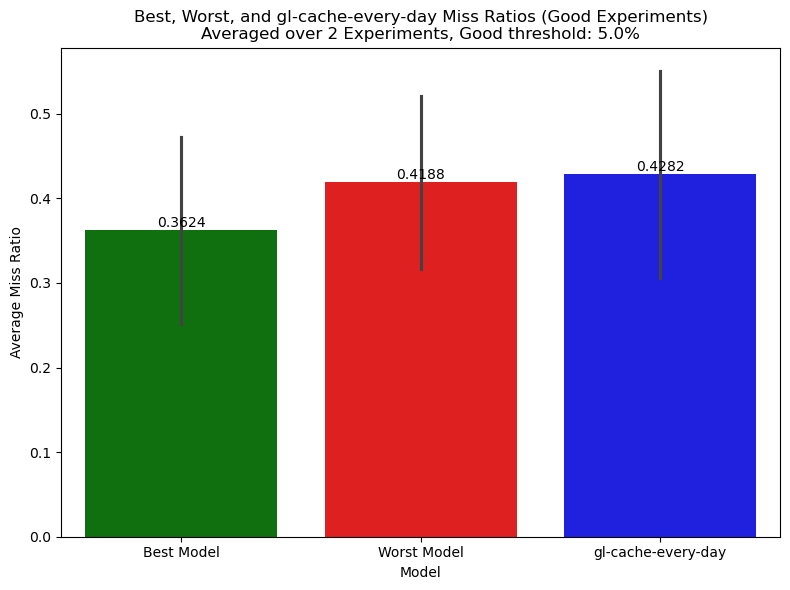

['ns6' 'ns3']


/tmp/ipykernel_570224/2748319212.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Algorithm', y='Value', data=filtered_df, palette=['green', 'red', 'blue'], errorbar="sd")


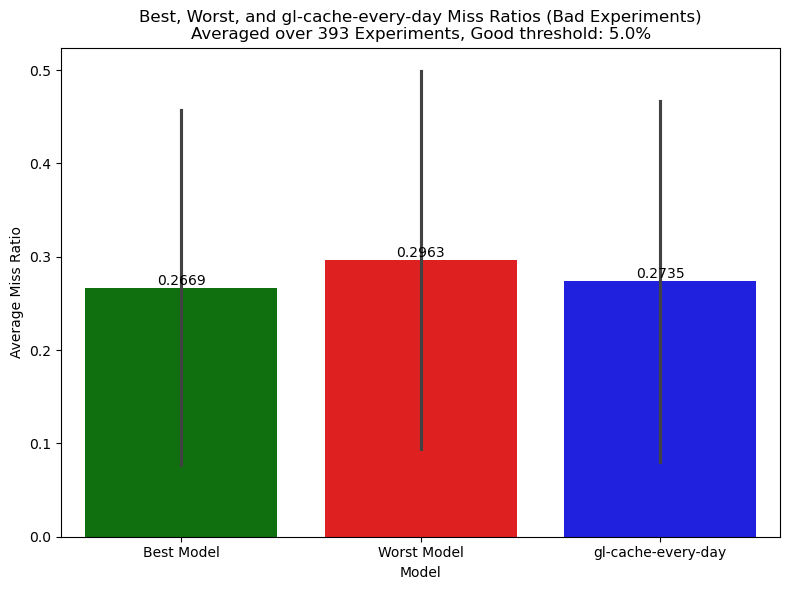

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV data into a DataFrame
df = pd.read_csv('best_worst_everyday_comparison.csv')

# Define the percentage threshold for classification
x_percent_threshold = 0.05  # 5% better performance required to classify as 'good'

# Create an empty DataFrame to store the results globally
global_df = pd.DataFrame(columns=['File', 'Best Miss Ratio', 'Worst Miss Ratio', 'Every-day Miss Ratio', 'Classification'])

# Loop through each File
for file in df['File'].unique():
    # Filter the DataFrame for the current file
    file_df = df[df['File'] == file]
    
    # Find the miss ratio for 'gl-cache-every-day'
    every_day_miss_ratio = file_df[file_df['Algorithm'] == 'gl-cache-every-day']['Miss Ratio'].values[0]
    
    # Exclude 'gl-cache-every-day' to find the best and worst algorithm
    non_every_day_algos = file_df[file_df['Algorithm'] != 'gl-cache-every-day']
    
    # Find the best and worst miss ratios
    best_miss_ratio = non_every_day_algos['Miss Ratio'].min()
    worst_miss_ratio = non_every_day_algos['Miss Ratio'].max()
    
    
    # Classify the file based on the percentage difference
    if every_day_miss_ratio - best_miss_ratio >= x_percent_threshold:
        classification = 'good' 
    else:
        classification = 'bad'  # 'gl-cache-every-day' does not perform better
    
    # Append the results for this file to the global DataFrame
    # make 3 rows, one for best, one for worst, one for every-day
    global_df = global_df._append({
        'File': file,
        'Algorithm': 'Best Model',
        'Value': best_miss_ratio,
        'Classification': classification
    }, ignore_index=True)
    global_df = global_df._append({
        'File': file,
        'Algorithm': 'Worst Model',
        'Value': worst_miss_ratio,
        'Classification': classification
    }, ignore_index=True)
    global_df = global_df._append({
        'File': file,
        'Algorithm': 'gl-cache-every-day',
        'Value': every_day_miss_ratio,
        'Classification': classification
    }, ignore_index=True)

# After processing all files, print the global DataFrame
print(global_df)

def plot_miss_ratios(df, classification, title):
    # Filter the DataFrame based on the classification ('good' or 'bad')
    filtered_df = df[df['Classification'] == classification]

    num_files = filtered_df['File'].nunique()
    # Create a bar plot with Seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Algorithm', y='Value', data=filtered_df, palette=['green', 'red', 'blue'], errorbar="sd")
    
    # Add labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height, f'{height:.4f}', ha="center", va="bottom")
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Average Miss Ratio')
    plt.title(f"{title}\nAveraged over {num_files} Experiments, Good threshold: {x_percent_threshold * 100}%")
    
    # Display the plot
    plt.tight_layout()
    plt.show()


# Plot the global DataFrame for 'good' and 'bad' classifications
plot_miss_ratios(global_df, 'good', 'Best, Worst, and gl-cache-every-day Miss Ratios (Good Experiments)')
# print all the good file names
print(global_df[global_df['Classification'] == 'good']['File'].unique())
plot_miss_ratios(global_df, 'bad', 'Best, Worst, and gl-cache-every-day Miss Ratios (Bad Experiments)')
